# Bank Customer Response Prediction
## Comprehensive Analysis with Visualizations

**Task:** Predict customer response to communications
- Target1: Email response
- Target2: SMS response

**Evaluation Metric:** Accuracy

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_palette('husl')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

print("All imports successful")

All imports successful


In [2]:
# Output path setup
PNG_PATH = 'result/png'
CSV_PATH = 'result/csv'

os.makedirs(PNG_PATH, exist_ok=True)
os.makedirs(CSV_PATH, exist_ok=True)

print("Output directories created:")
print(f"    PNG: {PNG_PATH}/")
print(f"    CSV: {CSV_PATH}/")

Output directories created:
    PNG: result/png/
    CSV: result/csv/


In [3]:
# Load Data
TRAIN_PATH = 'data/WORK_bank_data_train.csv'
TEST_PATH = 'data/WORK_WORK_BANK_DATA_test_sample.csv'

train_data = pd.read_csv(TRAIN_PATH, sep=';')
test_data = pd.read_csv(TEST_PATH, sep=';')

print(f"Training data: {train_data.shape[0]:,} rows, {train_data.shape[1]} columns")
print(f"Test data: {test_data.shape[0]:,} rows, {test_data.shape[1]} columns")

Training data: 985,477 rows, 22 columns
Test data: 63,098 rows, 18 columns


# Section 1: Exploratory Data Analysis

## 1.1 Dataset Overview

In [4]:
# Dataset Summary Table
summary_data = {
    "Metric": [
        "Total Samples",
        "Features",
        "Target Variables",
        "Training Set Size",
        "Test Set Size",
    ],
    "Value": [
        f"{train_data.shape[0]:,}",
        f"{train_data.shape[1] - 2}",
        "2 (Target1, Target2)",
        f"{train_data.shape[0]:,}",
        f"{test_data.shape[0]:,}",
    ],
}

summary_df = pd.DataFrame(summary_data)

display(
    summary_df.style
    .set_caption("Dataset Overview")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

Metric,Value
Total Samples,"985,477"
Features,20
Target Variables,"2 (Target1, Target2)"
Training Set Size,"985,477"
Test Set Size,"63,098"


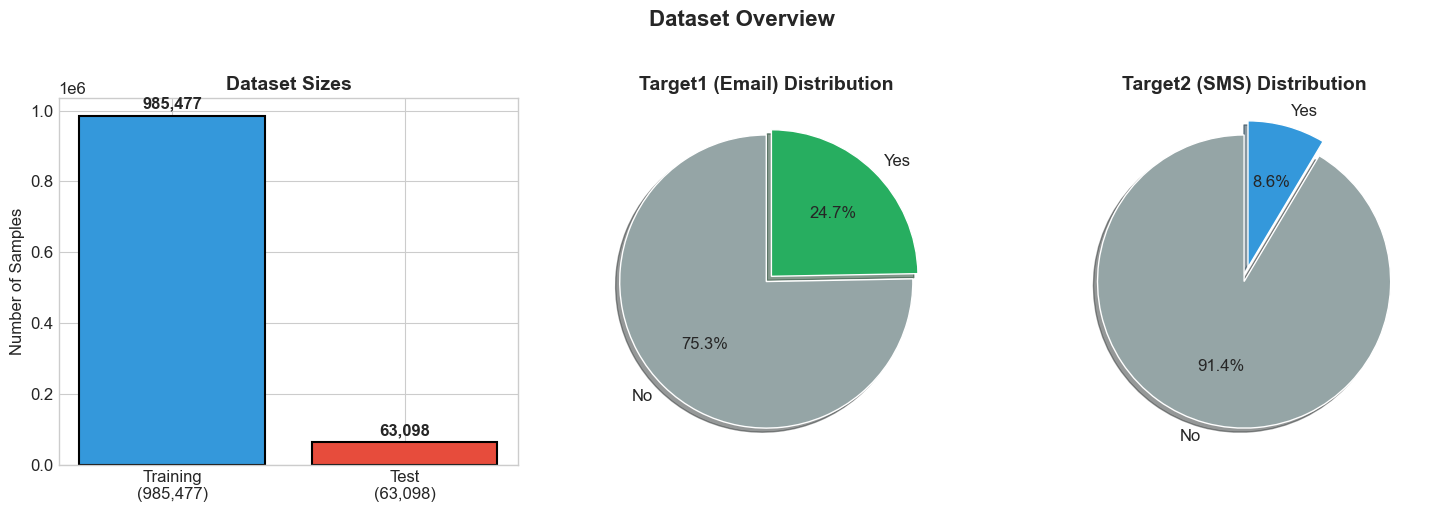

Saved: result/png/01_dataset_overview.png


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Dataset sizes
sizes = [train_data.shape[0], test_data.shape[0]]
labels = ['Training\n(985,477)', 'Test\n(63,098)']
colors = ['#3498db', '#e74c3c']
axes[0].bar(labels, sizes, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Dataset Sizes', fontweight='bold')
for i, v in enumerate(sizes):
    axes[0].text(i, v + 20000, f'{v:,}', ha='center', fontweight='bold')

# 2. Target1 Distribution
target1_counts = train_data['Target1'].value_counts()
axes[1].pie(target1_counts, labels=['No', 'Yes'], autopct='%1.1f%%', 
            colors=['#95a5a6', '#27ae60'], explode=(0, 0.05),
            shadow=True, startangle=90)
axes[1].set_title('Target1 (Email) Distribution', fontweight='bold')

# 3. Target2 Distribution
target2_counts = train_data['Target2'].value_counts()
axes[2].pie(target2_counts, labels=['No', 'Yes'], autopct='%1.1f%%',
            colors=['#95a5a6', '#3498db'], explode=(0, 0.1),
            shadow=True, startangle=90)
axes[2].set_title('Target2 (SMS) Distribution', fontweight='bold')

plt.suptitle('Dataset Overview', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/01_dataset_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/01_dataset_overview.png")

## 1.2 Target Class Imbalance Analysis

In [6]:
# Class imbalance table
imbalance_data = {
    "Target": [
        "Target1 (Email)",
        "Target2 (SMS)",
    ],
    "Positive (Yes)": [
        f"{(train_data['Target1']=='Yes').sum():,} ({(train_data['Target1']=='Yes').mean()*100:.1f}%)",
        f"{(train_data['Target2']=='Yes').sum():,} ({(train_data['Target2']=='Yes').mean()*100:.1f}%)",
    ],
    "Negative (No)": [
        f"{(train_data['Target1']=='No').sum():,} ({(train_data['Target1']=='No').mean()*100:.1f}%)",
        f"{(train_data['Target2']=='No').sum():,} ({(train_data['Target2']=='No').mean()*100:.1f}%)",
    ],
    "Imbalance Ratio": [
        f"1:{(train_data['Target1']=='No').sum() // (train_data['Target1']=='Yes').sum()}",
        f"1:{(train_data['Target2']=='No').sum() // (train_data['Target2']=='Yes').sum()}",
    ],
}

imbalance_df = pd.DataFrame(imbalance_data)

display(
    imbalance_df.style
    .set_caption("Class Imbalance Analysis")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

Target,Positive (Yes),Negative (No),Imbalance Ratio
Target1 (Email),"243,506 (24.7%)","741,971 (75.3%)",1:3
Target2 (SMS),"84,384 (8.6%)","901,093 (91.4%)",1:10


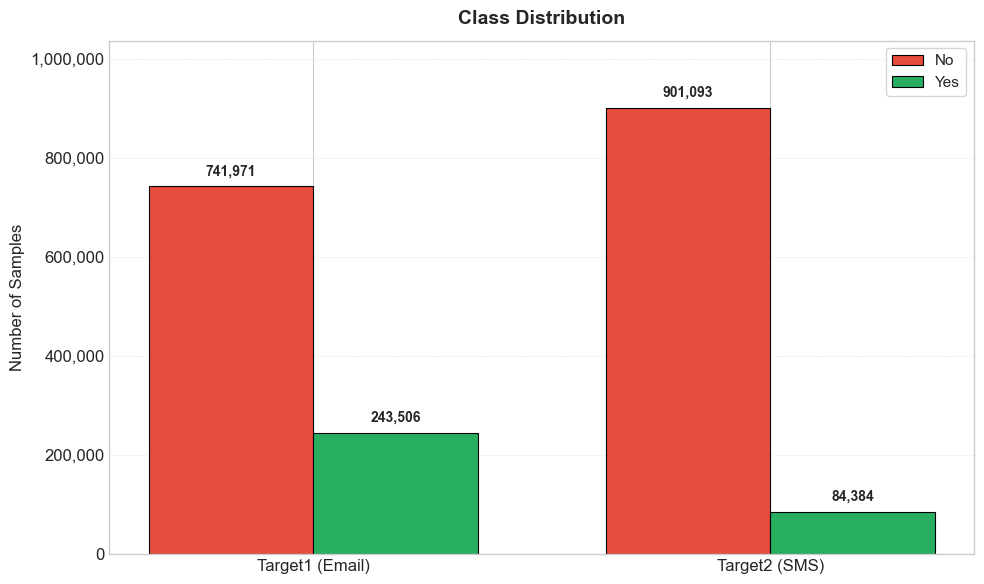

Saved: result/png/02_class_distribution.png


In [7]:
from matplotlib.ticker import FuncFormatter

# Simple class distribution visualization
targets = [("Target1 (Email)", "Target1"), ("Target2 (SMS)", "Target2")]

yes_counts = [(train_data[c] == "Yes").sum() for _, c in targets]
no_counts  = [(train_data[c] == "No").sum()  for _, c in targets]

x = np.arange(len(targets))
width = 0.36

fig, ax = plt.subplots(figsize=(10, 6))

bars_no = ax.bar(
    x - width/2, no_counts, width,
    label="No", color="#e74c3c", edgecolor="black", linewidth=0.8
)
bars_yes = ax.bar(
    x + width/2, yes_counts, width,
    label="Yes", color="#27ae60", edgecolor="black", linewidth=0.8
)

ax.set_title("Class Distribution", fontsize=14, fontweight="bold", pad=12)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([t for t, _ in targets], fontsize=12)
ax.legend(fontsize=11, frameon=True)

ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v):,}"))
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.35)
ax.set_axisbelow(True)

ymax = max(no_counts + yes_counts) if (no_counts + yes_counts) else 1
ax.set_ylim(0, ymax * 1.15)

def add_count_labels(bars, counts):
    for b, c in zip(bars, counts):
        ax.annotate(
            f"{c:,}",
            xy=(b.get_x() + b.get_width()/2, b.get_height()),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

add_count_labels(bars_no, no_counts)
add_count_labels(bars_yes, yes_counts)

plt.tight_layout()
plt.savefig(f'{PNG_PATH}/02_class_distribution.png', dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
print(f"Saved: {PNG_PATH}/02_class_distribution.png")

## 1.3 Feature Analysis

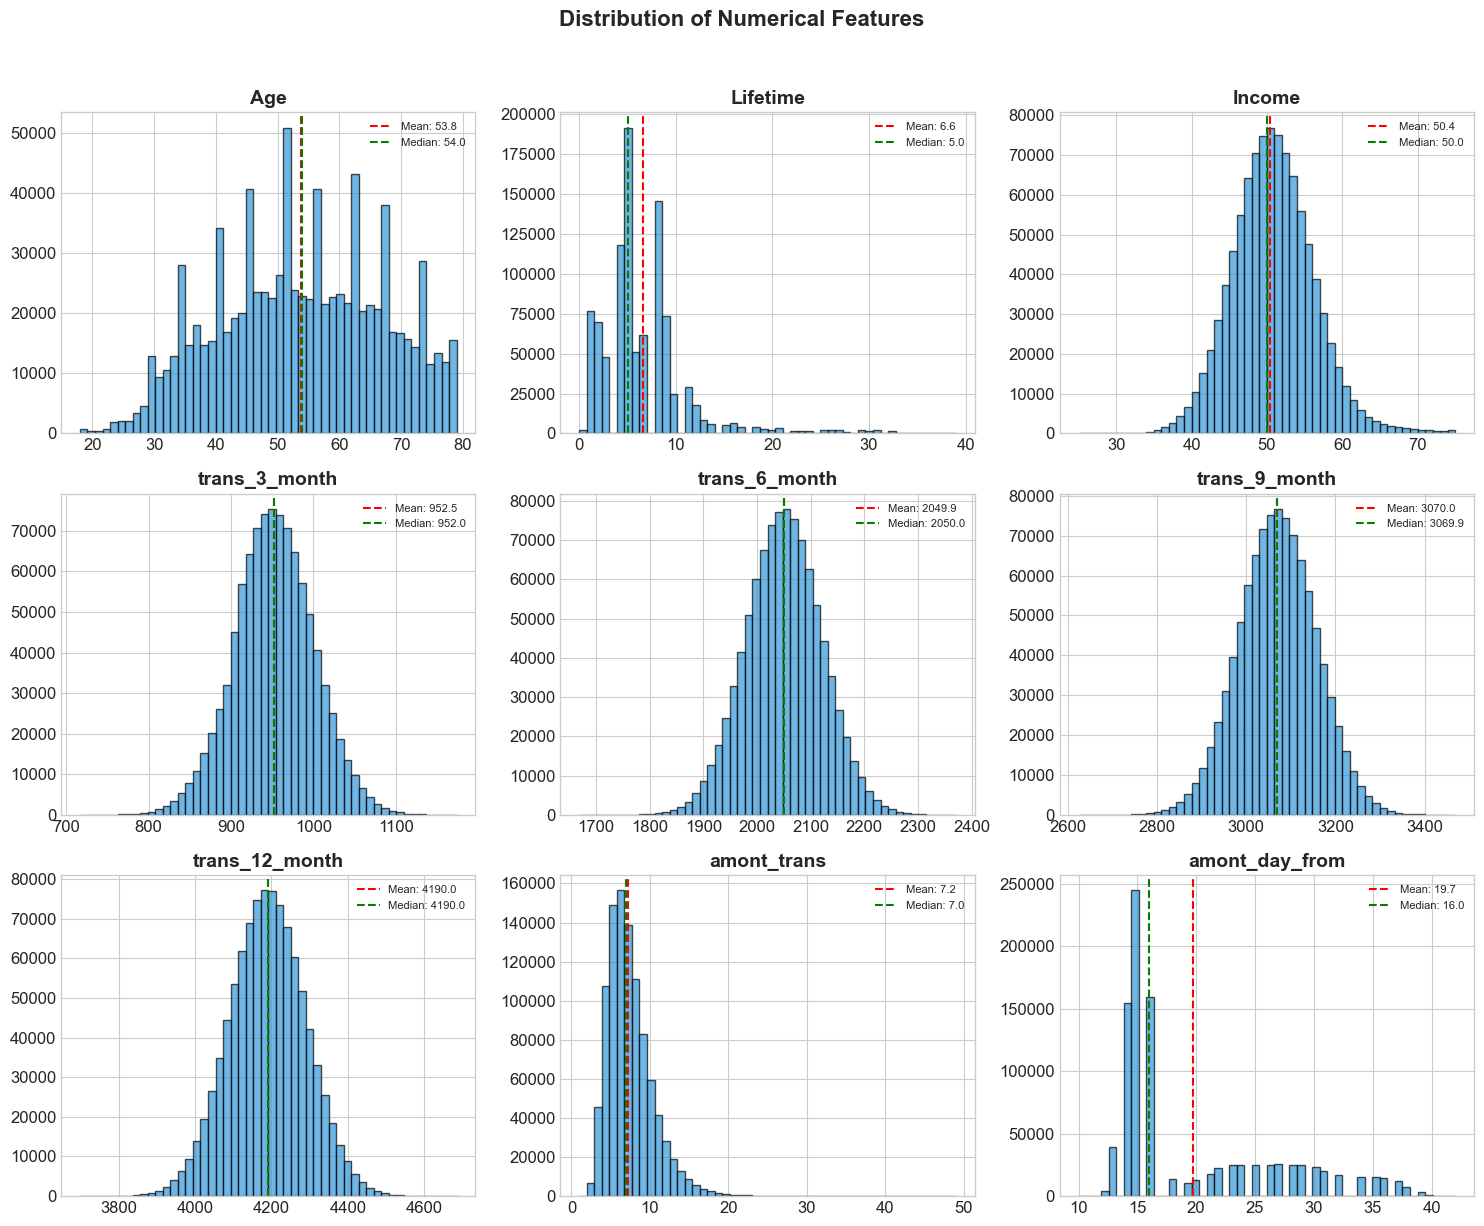

Saved: result/png/03_numerical_distributions.png


In [8]:
# Numerical features distribution
numerical_cols = ['Age', 'Lifetime', 'Income', 'trans_3_month', 'trans_6_month', 
                  'trans_9_month', 'trans_12_month', 'amont_trans', 'amont_day_from']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    if col in train_data.columns:
        ax = axes[idx]
        train_data[col].hist(bins=50, ax=ax, color='#3498db', edgecolor='black', alpha=0.7)
        ax.set_title(col, fontweight='bold')
        ax.set_xlabel('')
        
        mean_val = train_data[col].mean()
        median_val = train_data[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.1f}')
        ax.legend(fontsize=8)

plt.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/03_numerical_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/03_numerical_distributions.png")

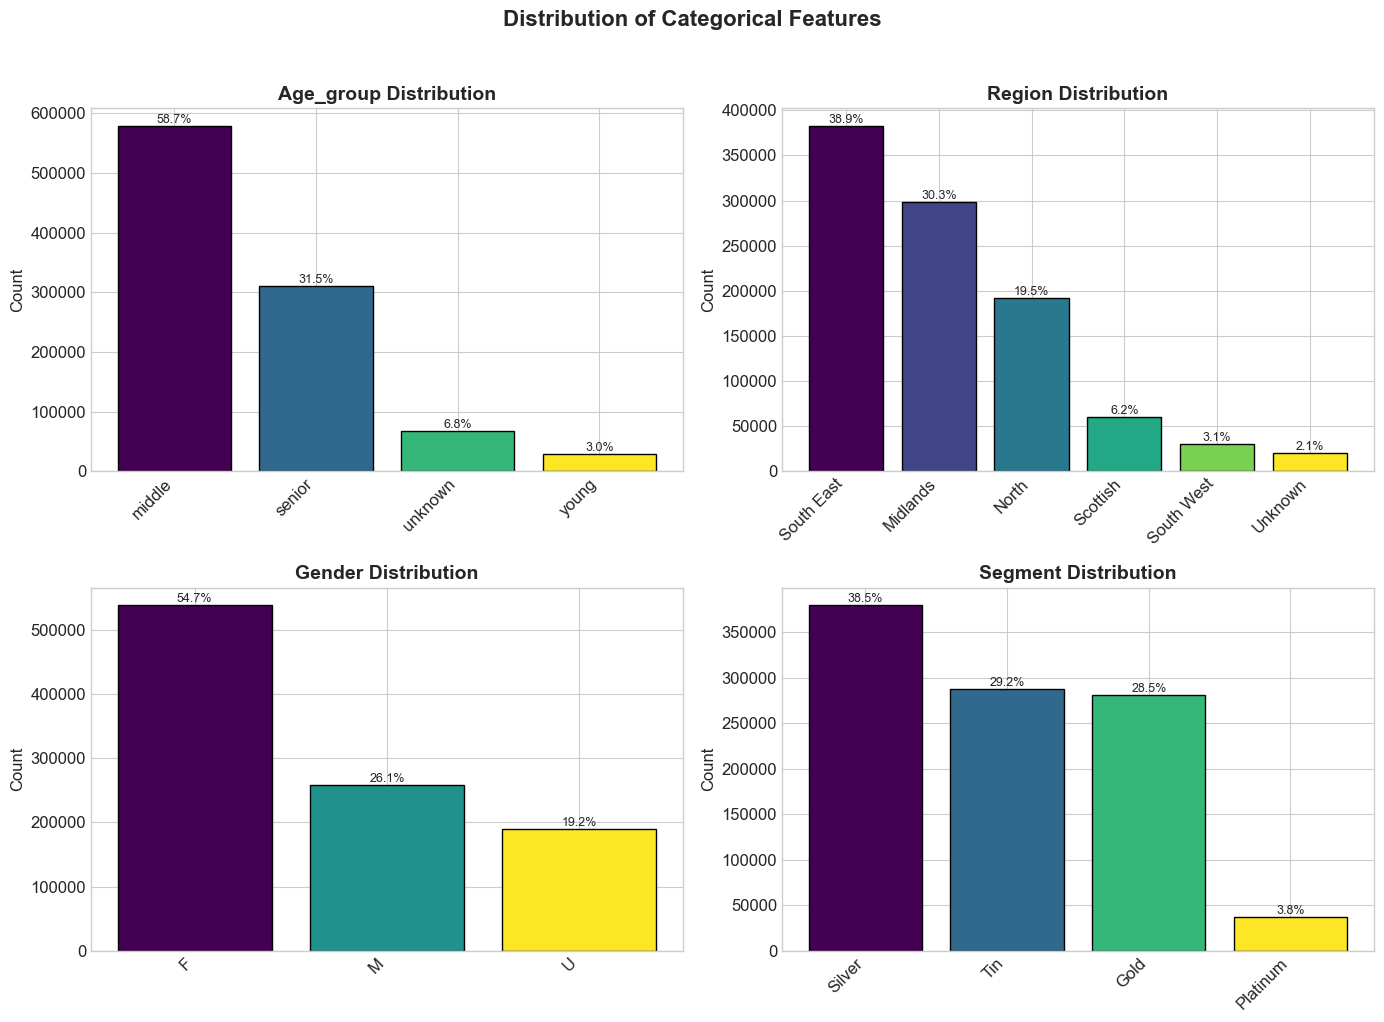

Saved: result/png/04_categorical_distributions.png


In [9]:
# Categorical features analysis
categorical_cols = ['Age_group', 'Region', 'Gender', 'Segment']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    if col in train_data.columns:
        ax = axes[idx]
        value_counts = train_data[col].value_counts()
        bars = ax.bar(range(len(value_counts)), value_counts.values, 
                      color=plt.cm.viridis(np.linspace(0, 1, len(value_counts))),
                      edgecolor='black')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        ax.set_title(f'{col} Distribution', fontweight='bold')
        ax.set_ylabel('Count')
        
        total = len(train_data)
        for bar, val in zip(bars, value_counts.values):
            pct = val / total * 100
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/04_categorical_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/04_categorical_distributions.png")

## 1.4 Missing Values Analysis

Feature,Missing Count,Missing %
Age,66958,6.790000
Lifetime,12608,1.280000


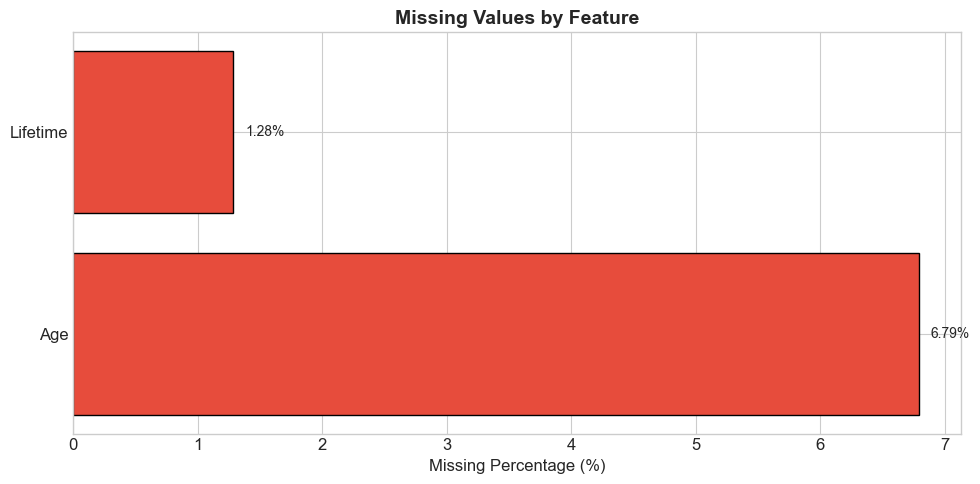

Saved: result/png/05_missing_values.png


In [10]:
# Missing values table and visualization
missing_train = train_data.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

if len(missing_train) > 0:
    missing_df = pd.DataFrame({
        "Feature": missing_train.index,
        "Missing Count": missing_train.values,
        "Missing %": (missing_train.values / len(train_data) * 100).round(2),
    })
    
    display(
        missing_df.style
        .set_caption("Missing Values Analysis")
        .set_properties(**{"text-align": "left"})
        .hide(axis="index")
        .background_gradient(subset=["Missing %"], cmap="Reds")
    )
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(missing_df['Feature'], missing_df['Missing %'], color='#e74c3c', edgecolor='black')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Feature', fontweight='bold')
    
    for bar, pct in zip(bars, missing_df['Missing %']):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'{pct:.2f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'{PNG_PATH}/05_missing_values.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Saved: {PNG_PATH}/05_missing_values.png")
else:
    print("No missing values in training data!")

## 1.5 Correlation Analysis

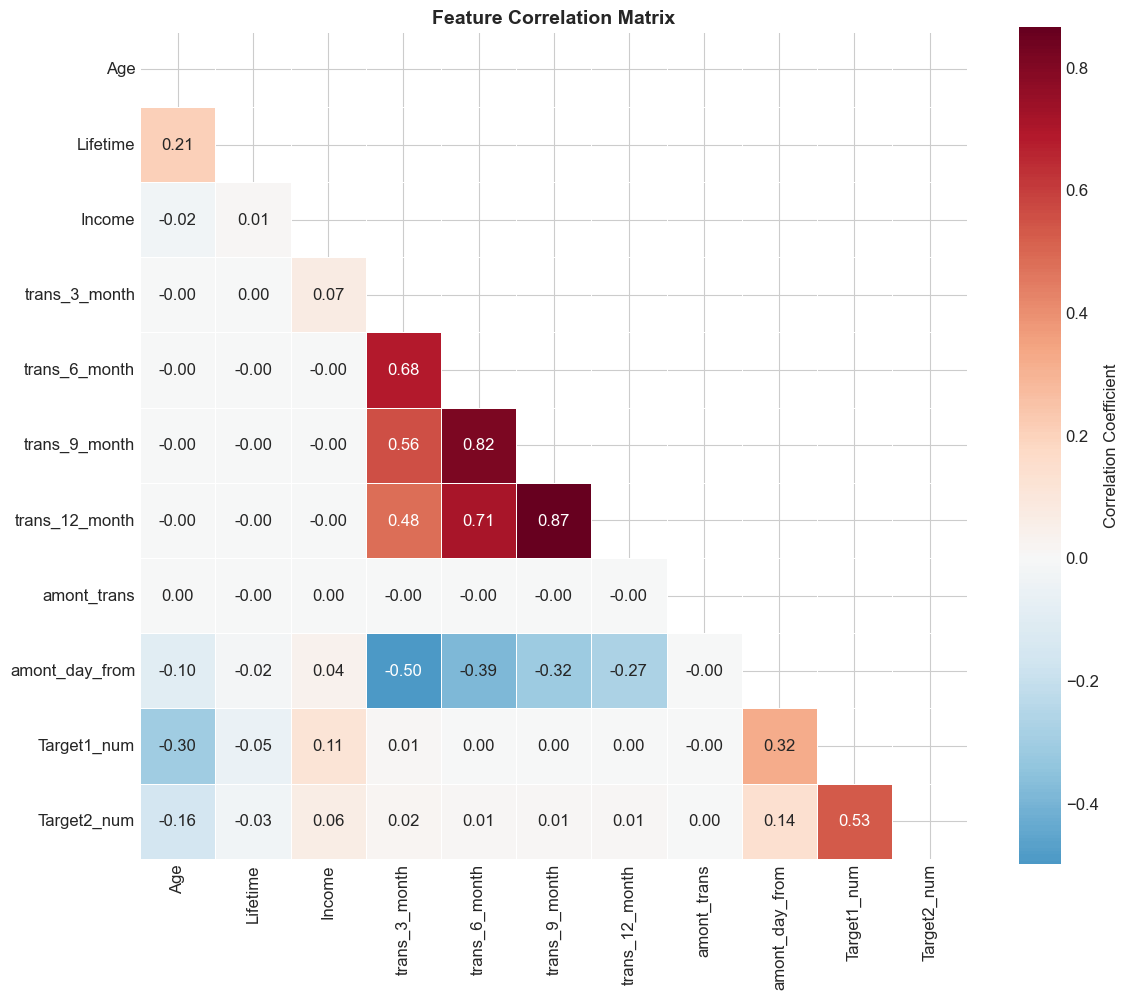

Saved: result/png/06_correlation_matrix.png


In [11]:
# Prepare data for correlation
train_corr = train_data.copy()
train_corr['Target1_num'] = (train_corr['Target1'] == 'Yes').astype(int)
train_corr['Target2_num'] = (train_corr['Target2'] == 'Yes').astype(int)

num_cols_for_corr = ['Age', 'Lifetime', 'Income', 'trans_3_month', 'trans_6_month',
                     'trans_9_month', 'trans_12_month', 'amont_trans', 'amont_day_from',
                     'Target1_num', 'Target2_num']
num_cols_for_corr = [c for c in num_cols_for_corr if c in train_corr.columns]

corr_matrix = train_corr[num_cols_for_corr].corr()

# Correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PNG_PATH}/06_correlation_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/06_correlation_matrix.png")

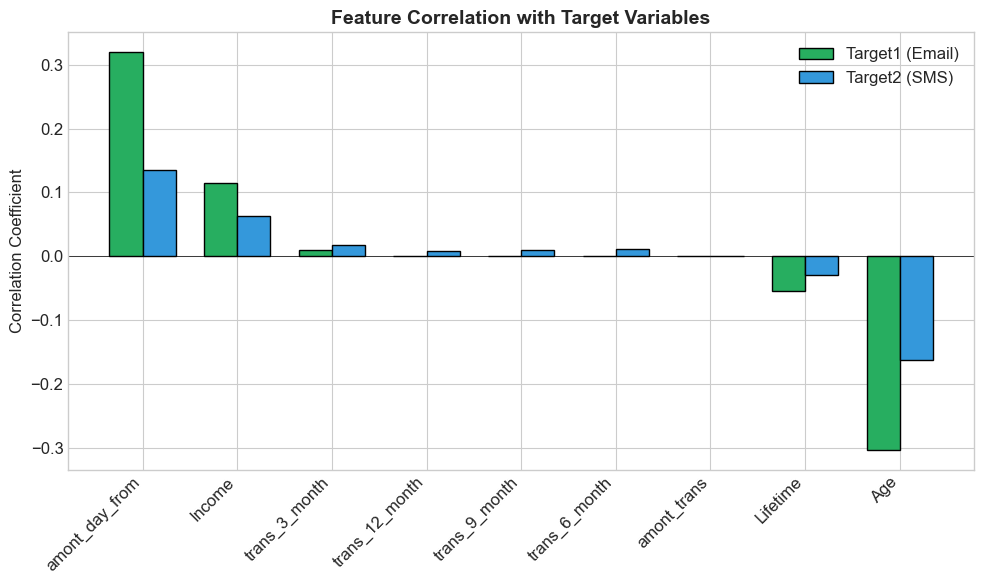

Saved: result/png/07_target_correlations.png


In [12]:
# Correlation with targets
target_corr = corr_matrix[['Target1_num', 'Target2_num']].drop(['Target1_num', 'Target2_num'])
target_corr = target_corr.sort_values('Target1_num', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(target_corr))
width = 0.35

bars1 = ax.bar(x - width/2, target_corr['Target1_num'], width, label='Target1 (Email)', 
               color='#27ae60', edgecolor='black')
bars2 = ax.bar(x + width/2, target_corr['Target2_num'], width, label='Target2 (SMS)',
               color='#3498db', edgecolor='black')

ax.set_ylabel('Correlation Coefficient')
ax.set_title('Feature Correlation with Target Variables', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_corr.index, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(f'{PNG_PATH}/07_target_correlations.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/07_target_correlations.png")

# Section 2: Data Preprocessing

In [13]:
# Data preprocessing functions
def handle_outliers(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.01)
            q99 = df[col].quantile(0.99)
            df[col] = df[col].clip(lower=q1, upper=q99)
    return df

def improved_clean_data(df, is_train=True):
    df = df.copy()
    if 'Ind_House_hold' in df.columns:
        df.rename(columns={'Ind_House_hold': 'Ind_Household'}, inplace=True)
    
    for col in ['Age', 'Lifetime']:
        if col in df.columns:
            df[f'{col}_missing'] = df[col].isna().astype(int)
            df[col] = df[col].fillna(df[col].median())
    
    binary_mapping = {'Yes': 1, 'No': 0, 'Y': 1, 'N': 0, 'YES': 1, 'NO': 0, 'yes': 1, 'no': 0}
    binary_cols = ['Ind_Household', 'Ind_deposit', 'Ind_salary']
    if is_train:
        binary_cols.extend(['Ind_email', 'Ind_phone'])
    
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map(binary_mapping)
            if df[col].isna().any():
                df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)
    
    df['District'] = pd.to_numeric(df['District'].astype(str), errors='coerce')
    df['District_invalid'] = df['District'].isna().astype(int)
    df['District'] = df['District'].fillna(-1)
    
    for col in ['Age_group', 'Region', 'Gender', 'Segment']:
        if col in df.columns:
            df[col] = df[col].replace('unknown', np.nan)
            dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            df.drop(col, axis=1, inplace=True)
    
    if all(c in df.columns for c in ['trans_6_month', 'trans_9_month', 'trans_12_month']):
        df['trans_mean'] = df[['trans_6_month', 'trans_9_month', 'trans_12_month']].mean(axis=1)
        df['trans_std'] = df[['trans_6_month', 'trans_9_month', 'trans_12_month']].std(axis=1).fillna(0)
        df['trans_9_to_6_ratio'] = np.where(df['trans_6_month'] > 0,
            df['trans_9_month'] / (df['trans_6_month'] + 1e-10), 0)
        df['trans_growth'] = df['trans_12_month'] - df['trans_6_month']
    
    if all(c in df.columns for c in ['Age', 'Income']):
        df['Age_Income'] = df['Age'] * df['Income']
        df['Income_per_Age'] = df['Income'] / (df['Age'] + 1e-10)
    
    numerical_cols = ['Age', 'Lifetime', 'Income', 'trans_6_month', 'trans_9_month', 'trans_12_month']
    df = handle_outliers(df, [c for c in numerical_cols if c in df.columns])
    
    if 'ID' in df.columns and is_train:
        df.drop('ID', axis=1, inplace=True)
    
    return df

# Apply preprocessing
train_clean = improved_clean_data(train_data, is_train=True)
test_clean = improved_clean_data(test_data, is_train=False)

print(f"Preprocessed training data: {train_clean.shape}")
print(f"Preprocessed test data: {test_clean.shape}")

Preprocessed training data: (985477, 42)
Preprocessed test data: (63098, 39)


In [14]:
# Feature Engineering Summary Table
feature_eng_data = {
    "Feature Type": [
        "Missing Indicators",
        "Transaction Aggregates",
        "Interaction Features",
        "Encoded Categories",
    ],
    "Features Created": [
        "Age_missing, Lifetime_missing, District_invalid",
        "trans_mean, trans_std, trans_9_to_6_ratio, trans_growth",
        "Age_Income, Income_per_Age",
        "One-hot encoding for Age_group, Region, Gender, Segment",
    ],
    "Purpose": [
        "Capture missingness patterns",
        "Summarize transaction behavior",
        "Capture feature interactions",
        "Handle categorical variables",
    ],
}

feature_eng_df = pd.DataFrame(feature_eng_data)

display(
    feature_eng_df.style
    .set_caption("Feature Engineering Summary")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

Feature Type,Features Created,Purpose
Missing Indicators,"Age_missing, Lifetime_missing, District_invalid",Capture missingness patterns
Transaction Aggregates,"trans_mean, trans_std, trans_9_to_6_ratio, trans_growth",Summarize transaction behavior
Interaction Features,"Age_Income, Income_per_Age",Capture feature interactions
Encoded Categories,"One-hot encoding for Age_group, Region, Gender, Segment",Handle categorical variables


In [15]:
# Prepare X and y
def prepare_data_for_model(df, target_cols=None):
    X = df.copy()
    if target_cols:
        y = {}
        for target in target_cols:
            if target in X.columns:
                y[target] = X[target]
                X.drop(target, axis=1, inplace=True)
        return X, y
    return X

X_train, y_train_dict = prepare_data_for_model(train_clean, target_cols=['Target1', 'Target2'])
test_ids = test_clean['ID'].copy()
X_test = test_clean.drop('ID', axis=1)

binary_mapping = {'Yes': 1, 'No': 0}
for target in ['Target1', 'Target2']:
    if target in y_train_dict:
        y_train_dict[target] = y_train_dict[target].map(binary_mapping).fillna(0)

# Align features
def align_features(X_train, X_test):
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)
    
    for col in train_cols - test_cols:
        X_test[col] = X_train[col].mode()[0] if not X_train[col].mode().empty else 0
    
    for col in test_cols - train_cols:
        X_test = X_test.drop(columns=[col])
    
    return X_train, X_test[X_train.columns]

X_train, X_test = align_features(X_train, X_test)
print(f"Final feature count: {X_train.shape[1]}")

Final feature count: 40


# Section 3: Model Training & Evaluation

In [16]:
def find_optimal_threshold(y_true, y_proba):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold, best_score = 0.5, 0
    for thresh in thresholds:
        score = accuracy_score(y_true, (y_proba >= thresh).astype(int))
        if score > best_score:
            best_score, best_threshold = score, thresh
    return best_threshold, best_score

def train_and_evaluate_models(X, y, target_name):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    pos_weight = len(y_tr[y_tr==0]) / max(len(y_tr[y_tr==1]), 1)
    
    models = {
        'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', C=0.1), True),
        'Random Forest': (RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, random_state=42, class_weight='balanced', n_jobs=-1), False),
        'XGBoost': (xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', scale_pos_weight=pos_weight), False),
        'LightGBM': (lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, class_weight='balanced', verbose=-1), False),
        'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_leaf=20, random_state=42, subsample=0.8), False)
    }
    
    if CATBOOST_AVAILABLE:
        models['CatBoost'] = (CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, random_seed=42, verbose=0, auto_class_weights='Balanced'), False)
    
    results = {}
    
    for name, (model, use_scaled) in models.items():
        X_t, X_v = (X_tr_scaled, X_val_scaled) if use_scaled else (X_tr, X_val)
        model.fit(X_t, y_tr)
        
        y_proba_val = model.predict_proba(X_v)[:, 1]
        y_proba_tr = model.predict_proba(X_t)[:, 1]
        
        threshold, _ = find_optimal_threshold(y_val, y_proba_val)
        y_pred_val = (y_proba_val >= threshold).astype(int)
        y_pred_tr = (y_proba_tr >= threshold).astype(int)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy_score(y_val, y_pred_val),
            'roc_auc': roc_auc_score(y_val, y_proba_val),
            'train_accuracy': accuracy_score(y_tr, y_pred_tr),
            'threshold': threshold,
            'scaler': scaler if use_scaled else None,
            'y_proba': y_proba_val,
            'y_pred': y_pred_val,
            'y_val': y_val
        }
    
    return results, X_tr, X_val, y_tr, y_val

# Train models
all_results = {}
best_models = {}

for target_name, y_target in y_train_dict.items():
    print(f"\nTraining models for {target_name}...")
    results, X_tr, X_val, y_tr, y_val = train_and_evaluate_models(X_train, y_target, target_name)
    all_results[target_name] = results
    
    best_name = max(results, key=lambda x: results[x]['accuracy'])
    best_models[target_name] = {
        'name': best_name,
        **results[best_name]
    }
    print(f"  Best: {best_name} (Accuracy: {results[best_name]['accuracy']:.4f})")


Training models for Target1...
  Best: Gradient Boosting (Accuracy: 0.9052)

Training models for Target2...
  Best: Gradient Boosting (Accuracy: 0.9663)


## 3.1 Model Comparison

In [25]:
# Create comprehensive model comparison tables
for target_name, results in all_results.items():
    comparison_data = {
        "Model": [],
        "Accuracy": [],
        "ROC-AUC": [],
        "Train Accuracy": [],
        "Overfit Gap": [],
        "Threshold": [],
    }
    
    for model_name, metrics in sorted(results.items(), key=lambda x: -x[1]['accuracy']):
        comparison_data["Model"].append(model_name)
        comparison_data["Accuracy"].append(f"{metrics['accuracy']:.4f}")
        comparison_data["ROC-AUC"].append(f"{metrics['roc_auc']:.4f}")
        comparison_data["Train Accuracy"].append(f"{metrics['train_accuracy']:.4f}")
        comparison_data["Overfit Gap"].append(f"{metrics['train_accuracy'] - metrics['accuracy']:.4f}")
        comparison_data["Threshold"].append(f"{metrics['threshold']:.2f}")
    
    comparison_df = pd.DataFrame(comparison_data)
    
    display(
        comparison_df.style
        .set_caption(f"Model Comparison - {target_name}")
        .set_properties(**{"text-align": "left"})
        .hide(axis="index")
        .apply(lambda x: ['background-color: #034078' if x.name == 0 else '' for i in x], axis=1)
    )
    
    # Save as CSV
    comparison_df.to_csv(f'{CSV_PATH}/table_model_comparison_{target_name}.csv', index=False)
    print(f"Saved: {CSV_PATH}/table_model_comparison_{target_name}.csv\n")

Model,Accuracy,ROC-AUC,Train Accuracy,Overfit Gap,Threshold
Gradient Boosting,0.9052,0.9373,0.9051,-0.0001,0.50
LightGBM,0.9049,0.9378,0.9046,-0.0003,0.74
XGBoost,0.9047,0.9382,0.9045,-0.0002,0.75
CatBoost,0.9025,0.9346,0.9018,-0.0008,0.74
Random Forest,0.9022,0.9337,0.9065,0.0043,0.73
Logistic Regression,0.8136,0.8373,0.8139,0.0003,0.71


Saved: result/csv/table_model_comparison_Target1.csv



Model,Accuracy,ROC-AUC,Train Accuracy,Overfit Gap,Threshold
Gradient Boosting,0.9663,0.9796,0.9657,-0.0006,0.51
LightGBM,0.9656,0.9804,0.9650,-0.0006,0.89
XGBoost,0.9656,0.9803,0.9649,-0.0007,0.89
CatBoost,0.9649,0.9796,0.9642,-0.0007,0.89
Random Forest,0.9279,0.9151,0.9352,0.0073,0.81
Logistic Regression,0.9093,0.7643,0.9091,-0.0002,0.89


Saved: result/csv/table_model_comparison_Target2.csv



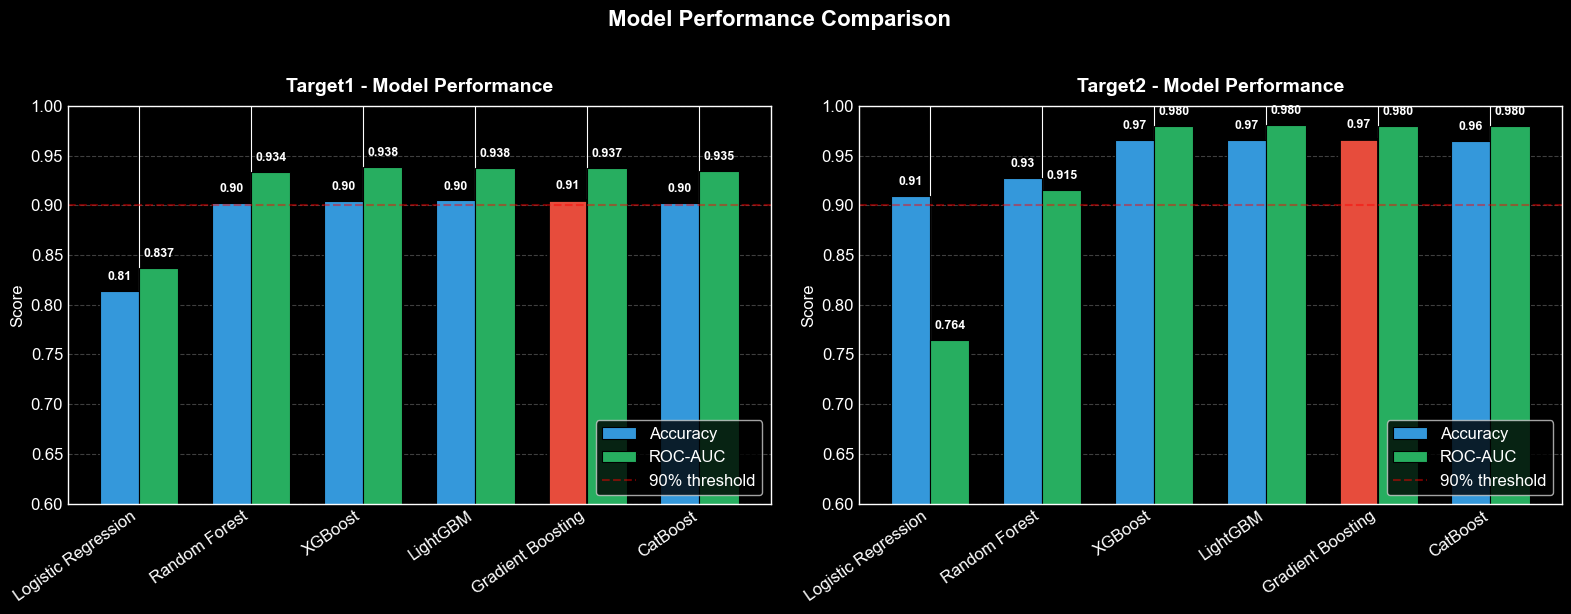

Saved: 08_model_comparison.png


In [28]:
# Model Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (target_name, results) in enumerate(all_results.items()):
    ax = axes[idx]

    models = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in models]
    roc_aucs = [results[m]['roc_auc'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy',
                   color='#3498db', edgecolor='black', linewidth=0.8)
    bars2 = ax.bar(x + width/2, roc_aucs, width, label='ROC-AUC',
                   color='#27ae60', edgecolor='black', linewidth=0.8)

    ax.set_ylabel('Score')
    ax.set_title(f'{target_name} - Model Performance', fontweight='bold', fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=35, ha='right')
    ax.set_ylim(0.6, 1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.set_axisbelow(True)

    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.45)

    best_idx = accuracies.index(max(accuracies))
    bars1[best_idx].set_color('#e74c3c')
    bars1[best_idx].set_edgecolor('black')
    bars1[best_idx].set_linewidth(2)

    for b, v in zip(bars1, accuracies):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.008, f'{v:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    for b, v in zip(bars2, roc_aucs):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.008, f'{v:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.45))
    labels.append('90% threshold')
    ax.legend(handles, labels, loc='lower right', frameon=True)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/08_model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/08_model_comparison.png")

## 3.2 Feature Importance

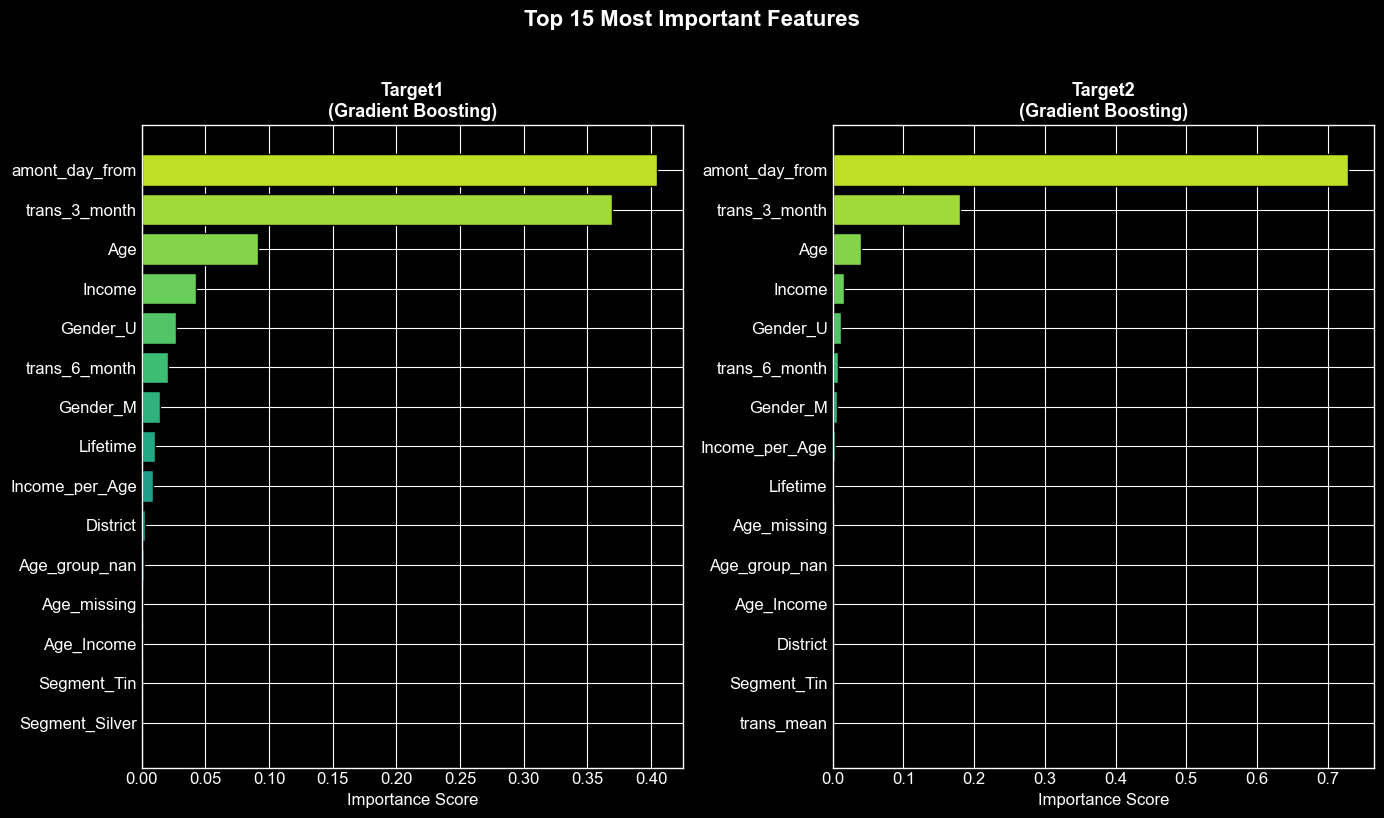

Saved: result/png/09_feature_importance.png
Saved: result/csv/table_feature_importance_Target1.csv
Saved: result/csv/table_feature_importance_Target2.csv


In [19]:
# Feature importance for best models
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, (target_name, model_info) in enumerate(best_models.items()):
    ax = axes[idx]
    model = model_info['model']
    
    if hasattr(model, 'feature_importances_'):
        if hasattr(model, 'feature_names_in_'):
            features = model.feature_names_in_
        else:
            features = X_train.columns
        
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=True).tail(15)
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
        bars = ax.barh(importance_df['Feature'], importance_df['Importance'], 
                       color=colors, edgecolor='black')
        
        ax.set_xlabel('Importance Score', fontsize=12)
        ax.set_title(f"{target_name}\n({model_info['name']})", fontweight='bold', fontsize=13)
        
        # Save feature importance table
        importance_df.sort_values('Importance', ascending=False).to_csv(
            f'{CSV_PATH}/table_feature_importance_{target_name}.csv', index=False)

plt.suptitle('Top 15 Most Important Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/09_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/09_feature_importance.png")
print(f"Saved: {CSV_PATH}/table_feature_importance_Target1.csv")
print(f"Saved: {CSV_PATH}/table_feature_importance_Target2.csv")

In [20]:
# Display feature importance tables
for target_name, model_info in best_models.items():
    model = model_info['model']
    
    if hasattr(model, 'feature_importances_'):
        if hasattr(model, 'feature_names_in_'):
            features = model.feature_names_in_
        else:
            features = X_train.columns
        
        importance_df = pd.DataFrame({
            "Rank": range(1, 11),
            "Feature": features[np.argsort(model.feature_importances_)[::-1][:10]],
            "Importance": np.sort(model.feature_importances_)[::-1][:10].round(4),
        })
        
        display(
            importance_df.style
            .set_caption(f"Top 10 Features - {target_name} ({model_info['name']})")
            .set_properties(**{"text-align": "left"})
            .hide(axis="index")
            .background_gradient(subset=["Importance"], cmap="Greens")
        )

Rank,Feature,Importance
1,amont_day_from,0.404900
2,trans_3_month,0.369500
3,Age,0.091200
4,Income,0.043000
5,Gender_U,0.026600
6,trans_6_month,0.020900
7,Gender_M,0.014800
8,Lifetime,0.010700
9,Income_per_Age,0.009200
10,District,0.002400


Rank,Feature,Importance
1,amont_day_from,0.729000
2,trans_3_month,0.180800
3,Age,0.040700
4,Income,0.015700
5,Gender_U,0.011200
6,trans_6_month,0.007600
7,Gender_M,0.005700
8,Income_per_Age,0.004000
9,Lifetime,0.002100
10,Age_missing,0.000700


# Section 4: Final Predictions

In [29]:
# Generate predictions using already trained models
predictions_df = pd.DataFrame({'ID': test_ids})

thresholds_used = {}

for target_name, model_info in best_models.items():
    model = model_info['model']
    scaler = model_info['scaler']

    # Prepare test data
    X_test_final = X_test.copy()
    if hasattr(model, 'feature_names_in_'):
        X_test_final = X_test_final.reindex(columns=model.feature_names_in_, fill_value=0)
    if scaler:
        X_test_final = scaler.transform(X_test_final)

    # Get probabilities
    proba = model.predict_proba(X_test_final)[:, 1]

    # Set threshold based on expected positive rate from training data
    if target_name == 'Target1':
        # ~24.7% positive in training → use percentile-based threshold
        threshold = np.percentile(proba, 75)  # Top 25% predicted as Yes
    else:  # Target2
        # ~8.6% positive in training → use percentile-based threshold
        threshold = np.percentile(proba, 91)  # Top 9% predicted as Yes

    pred = (proba >= threshold).astype(int)

    predictions_df[f'{target_name}_prob'] = proba
    predictions_df[f'{target_name}_pred'] = pred
    predictions_df[target_name] = np.where(pred == 1, 'Yes', 'No')

    thresholds_used[target_name] = threshold

    print(f"{target_name}:")
    print(f"  Threshold: {threshold:.4f}")
    print(f"  Predictions: {pred.sum()} Yes ({pred.sum()/len(pred)*100:.1f}%), {len(pred)-pred.sum()} No")
    print()

# Save
predictions_df[['ID', 'Target1', 'Target2']].to_csv(f'{CSV_PATH}/WORK_bank_predictions_final.csv', index=False)
predictions_df.to_csv(f'{CSV_PATH}/WORK_bank_predictions_full.csv', index=False)
print(f"\nSaved: {CSV_PATH}/WORK_bank_predictions_final.csv")
print(f"Saved: {CSV_PATH}/WORK_bank_predictions_full.csv")

Target1:
  Threshold: 0.2025
  Predictions: 15780 Yes (25.0%), 47318 No

Target2:
  Threshold: 0.0070
  Predictions: 5852 Yes (9.3%), 57246 No


Saved: result/csv/WORK_bank_predictions_final.csv
Saved: result/csv/WORK_bank_predictions_full.csv


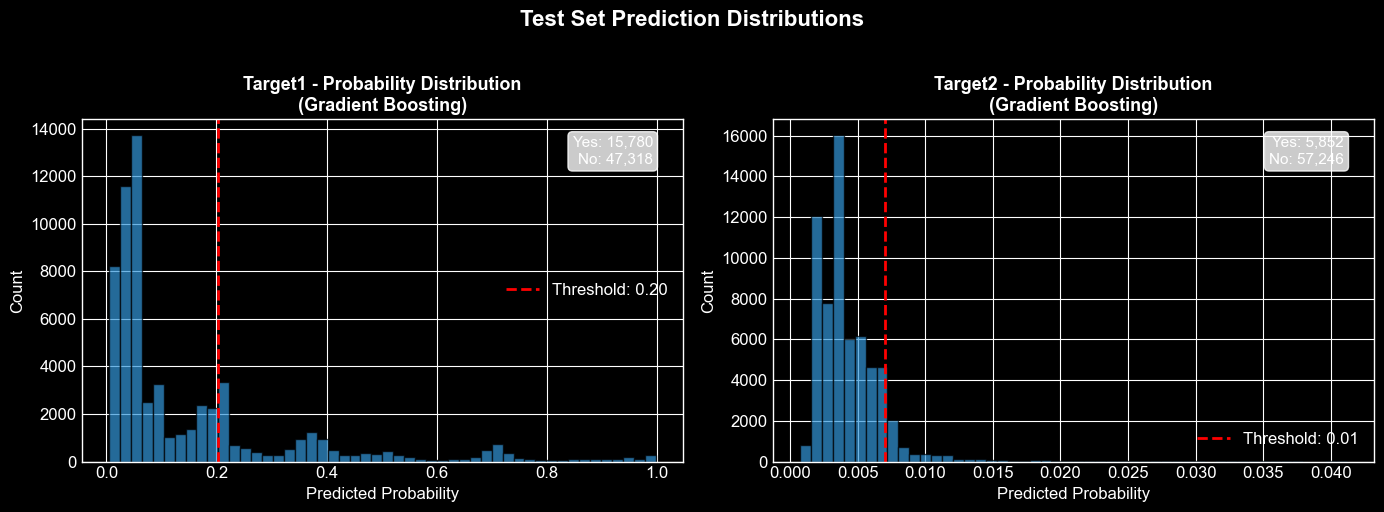

Saved: result/png/10_prediction_distributions.png


In [30]:
# Prediction distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, target_name in enumerate(['Target1', 'Target2']):
    ax = axes[idx]
    
    proba = predictions_df[f'{target_name}_prob']
    threshold = thresholds_used[target_name]

    ax.hist(proba, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2,
               label=f'Threshold: {threshold:.2f}')

    ax.set_xlabel('Predicted Probability', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{target_name} - Probability Distribution\n({best_models[target_name]["name"]})',
                 fontweight='bold', fontsize=13)
    ax.legend()

    n_yes = (proba >= threshold).sum()
    n_no = len(proba) - n_yes
    ax.text(0.95, 0.95, f'Yes: {n_yes:,}\nNo: {n_no:,}', transform=ax.transAxes,
            ha='right', va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Test Set Prediction Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/10_prediction_distributions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/10_prediction_distributions.png")

# Section 5: Summary & Conclusions

In [31]:
# Final Summary Table
summary_results = {
    "Target": [],
    "Best Model": [],
    "Validation Accuracy": [],
    "ROC-AUC": [],
    "Optimal Threshold": [],
    "Predicted Yes": [],
    "Predicted No": [],
}

for target_name, model_info in best_models.items():
    summary_results["Target"].append(target_name)
    summary_results["Best Model"].append(model_info['name'])
    summary_results["Validation Accuracy"].append(f"{model_info['accuracy']:.2%}")
    summary_results["ROC-AUC"].append(f"{model_info['roc_auc']:.4f}")
    summary_results["Optimal Threshold"].append(f"{model_info['threshold']:.2f}")
    summary_results["Predicted Yes"].append(f"{predictions_df[f'{target_name}_pred'].sum():,}")
    summary_results["Predicted No"].append(f"{len(predictions_df) - predictions_df[f'{target_name}_pred'].sum():,}")

summary_df = pd.DataFrame(summary_results)

display(
    summary_df.style
    .set_caption("Final Results Summary")
    .set_properties(**{"text-align": "left"})
    .hide(axis="index")
)

summary_df.to_csv(f'{CSV_PATH}/table_final_summary.csv', index=False)
print(f"Saved: {CSV_PATH}/table_final_summary.csv")

Target,Best Model,Validation Accuracy,ROC-AUC,Optimal Threshold,Predicted Yes,Predicted No
Target1,Gradient Boosting,90.52%,0.9373,0.50,"15,780","47,318"
Target2,Gradient Boosting,96.63%,0.9796,0.51,"5,852","57,246"


Saved: result/csv/table_final_summary.csv


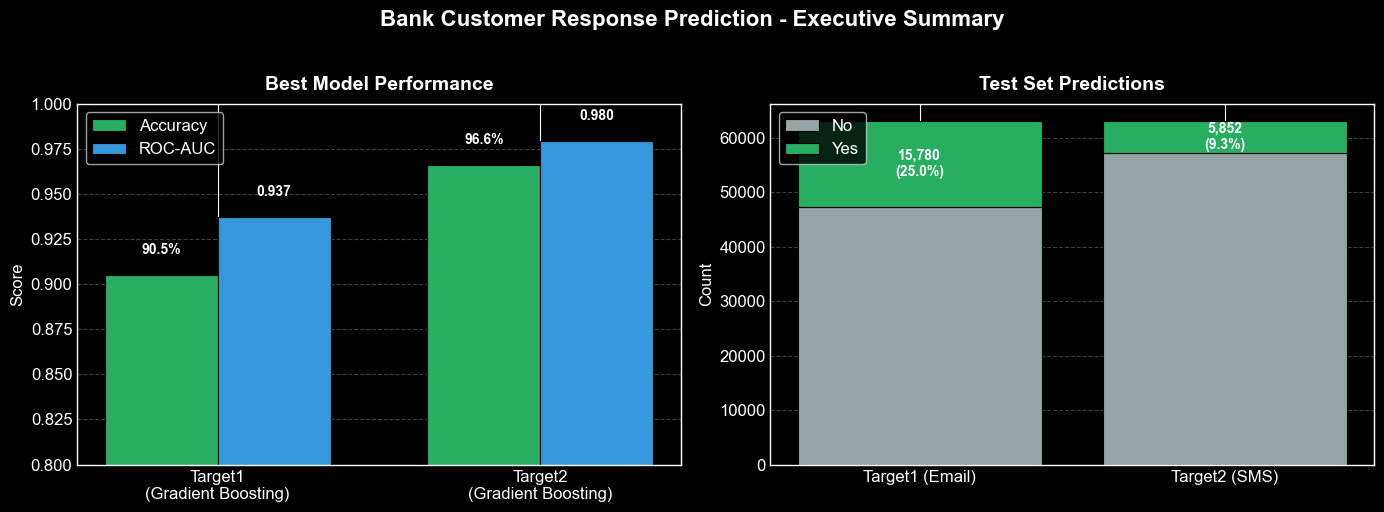

Saved: result/png/11_executive_summary.png

KEY FINDINGS & CONCLUSIONS
Dataset: 985,477 training samples, 63,098 test samples

Target1 (Email Response):
   Best Model: Gradient Boosting
   Accuracy: 90.52%
   ROC-AUC: 0.9373
   Predicted 15,780 positive responses (25.0%)

Target2 (SMS Response):
   Best Model: Gradient Boosting
   Accuracy: 96.63%
   ROC-AUC: 0.9796
   Predicted 5,852 positive responses (9.3%)


In [32]:
fig = plt.figure(figsize=(14, 5))

# Model Performance
ax1 = fig.add_subplot(1, 2, 1)

targets = ['Target1', 'Target2']
x = np.arange(len(targets))
width = 0.35

accuracies = [best_models[t]['accuracy'] for t in targets]
roc_aucs = [best_models[t]['roc_auc'] for t in targets]

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy',
                color='#27ae60', edgecolor='black', linewidth=0.8)
bars2 = ax1.bar(x + width/2, roc_aucs, width, label='ROC-AUC',
                color='#3498db', edgecolor='black', linewidth=0.8)

ax1.set_ylabel('Score')
ax1.set_title('Best Model Performance', fontweight='bold', pad=10)
ax1.set_xticks(x)
ax1.set_xticklabels([f"{t}\n({best_models[t]['name']})" for t in targets])
ax1.set_ylim(0.8, 1.0)
ax1.grid(axis='y', linestyle='--', alpha=0.25)
ax1.set_axisbelow(True)
ax1.legend(frameon=True)

for bar, val in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.1%}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)
for bar, val in zip(bars2, roc_aucs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Prediction Distribution
ax2 = fig.add_subplot(1, 2, 2)

yes_counts = [predictions_df['Target1_pred'].sum(), predictions_df['Target2_pred'].sum()]
no_counts = [len(predictions_df) - yes_counts[0], len(predictions_df) - yes_counts[1]]

ax2.bar(x, no_counts, label='No', color='#95a5a6', edgecolor='black', linewidth=0.8)
ax2.bar(x, yes_counts, bottom=no_counts, label='Yes', color='#27ae60', edgecolor='black', linewidth=0.8)

ax2.set_ylabel('Count')
ax2.set_title('Test Set Predictions', fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(['Target1 (Email)', 'Target2 (SMS)'])
ax2.grid(axis='y', linestyle='--', alpha=0.25)
ax2.set_axisbelow(True)
ax2.legend(frameon=True)

for i, (y, n) in enumerate(zip(yes_counts, no_counts)):
    ax2.text(i, n + y/2, f'{y:,}\n({y/len(predictions_df)*100:.1f}%)',
             ha='center', va='center', fontweight='bold', color='white', fontsize=10)

plt.suptitle('Bank Customer Response Prediction - Executive Summary',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{PNG_PATH}/11_executive_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {PNG_PATH}/11_executive_summary.png")

# Key Findings
t1_yes = predictions_df['Target1_pred'].sum()
t2_yes = predictions_df['Target2_pred'].sum()

print()
print("KEY FINDINGS & CONCLUSIONS")
print(f"Dataset: {train_data.shape[0]:,} training samples, {test_data.shape[0]:,} test samples")
print()
print("Target1 (Email Response):")
print(f"   Best Model: {best_models['Target1']['name']}")
print(f"   Accuracy: {best_models['Target1']['accuracy']:.2%}")
print(f"   ROC-AUC: {best_models['Target1']['roc_auc']:.4f}")
print(f"   Predicted {t1_yes:,} positive responses ({t1_yes/len(predictions_df)*100:.1f}%)")
print()
print("Target2 (SMS Response):")
print(f"   Best Model: {best_models['Target2']['name']}")
print(f"   Accuracy: {best_models['Target2']['accuracy']:.2%}")
print(f"   ROC-AUC: {best_models['Target2']['roc_auc']:.4f}")
print(f"   Predicted {t2_yes:,} positive responses ({t2_yes/len(predictions_df)*100:.1f}%)")